In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.pipeline import Pipeline
from collections import Counter
import lime
import lime.lime_tabular
import xgboost as xgb
import seaborn as sns
import shap
shap.initjs()

C:\Users\larre\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\larre\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\Users\larre\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df = pd.read_csv("Loan_default.csv")
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [3]:
# One-hot encoding categorical variables
categorical_cols = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose', 'HasMortgage', 'HasDependents', 'HasCoSigner']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_encoded = df_encoded.head(1000)
df_encoded.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasMortgage_Yes,HasDependents_Yes,HasCoSigner_Yes
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,...,False,False,False,False,False,False,True,True,True,True
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,...,False,True,False,False,False,False,True,False,False,True
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,...,True,False,False,False,False,False,False,True,True,False
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,...,False,True,False,True,False,False,False,False,False,False
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,...,True,False,False,False,False,False,False,False,True,False


In [4]:
# Define features and target variable
features = df_encoded.drop(columns=['LoanID', 'Default'])  
target = df_encoded['Default']

# Check the class distribution before sampling
print("Class distribution before sampling:", Counter(target))

# Determine the number of samples in the minority class
minority_class_samples = sum(target == 1)

# Define the sampling strategy
sampling_strategy = {1: minority_class_samples * 2}  # For example, 2 times the number of samples in the minority class for the majority class

# Define the oversampling and undersampling pipelines
over_sampling = RandomOverSampler(sampling_strategy=sampling_strategy)
under_sampling = RandomUnderSampler(sampling_strategy=sampling_strategy)

# Create the pipeline for resampling
resampling_pipeline = Pipeline([
    ('over_sampling', over_sampling),
    ('under_sampling', under_sampling)
])

# Apply the resampling pipeline to the data
X_resampled, y_resampled = resampling_pipeline.fit_resample(features, target)

# Check the class distribution after sampling
print("Class distribution after sampling:", Counter(y_resampled))

Class distribution before sampling: Counter({0: 881, 1: 119})
Class distribution after sampling: Counter({0: 881, 1: 238})


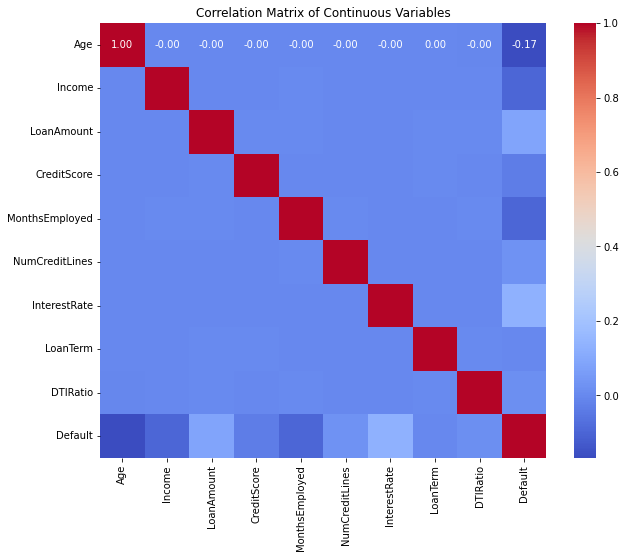

In [5]:
# Select only the continuous variables from your DataFrame
continuous_vars = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = continuous_vars.corr()

# Plot the correlation matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title("Correlation Matrix of Continuous Variables")
plt.show()

## Model Creation

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [7]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = rf_model.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       190
           1       1.00      0.68      0.81        34

    accuracy                           0.95       224
   macro avg       0.97      0.84      0.89       224
weighted avg       0.95      0.95      0.95       224



## LIME Explanations

In [8]:
# LIME
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   feature_names=X_train.columns.tolist(),
                                                   class_names=['Non-Default', 'Default'],
                                                   discretize_continuous=True)

# Select an instance from the test set to explain
instance_idx = 0
instance = X_test.iloc[[instance_idx]].values[0]
explanation = explainer.explain_instance(instance,
                                         rf_model.predict_proba,
                                         num_features=len(X_train.columns))

# Print LIME explanation
print("LIME Explanation for instance", instance_idx)
print(explanation.as_list())



C:\Users\larre\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


LIME Explanation for instance 0
[('43.00 < Age <= 54.00', -0.06189900625471223), ('Income <= 49690.00', 0.04480139402781591), ('CreditScore <= 443.50', 0.032826257559497654), ('14.44 < InterestRate <= 19.98', 0.03278468522020541), ('LoanAmount > 188509.50', 0.02684262956283879), ('LoanTerm <= 24.00', 0.01776076999400516), ('58.00 < MonthsEmployed <= 88.00', -0.015915874981280467), ('0.00 < EmploymentType_Unemployed <= 1.00', 0.013453592048625526), ('MaritalStatus_Married <= 0.00', 0.012998946081439346), ('NumCreditLines > 3.00', 0.0110753134878277), ('LoanPurpose_Other <= 0.00', -0.010383903122307737), ('EmploymentType_Part-time <= 0.00', -0.009687596468126398), ('HasCoSigner_Yes <= 0.00', 0.008595191341568635), ('DTIRatio <= 0.30', -0.008160322235020048), ('LoanPurpose_Education > 0.00', 0.006311695231991879), ('EmploymentType_Self-employed <= 0.00', -0.005453799759933513), ('LoanPurpose_Home <= 0.00', -0.004215984448453703), ("Education_Master's > 0.00", -0.004203895197277833), ('Edu

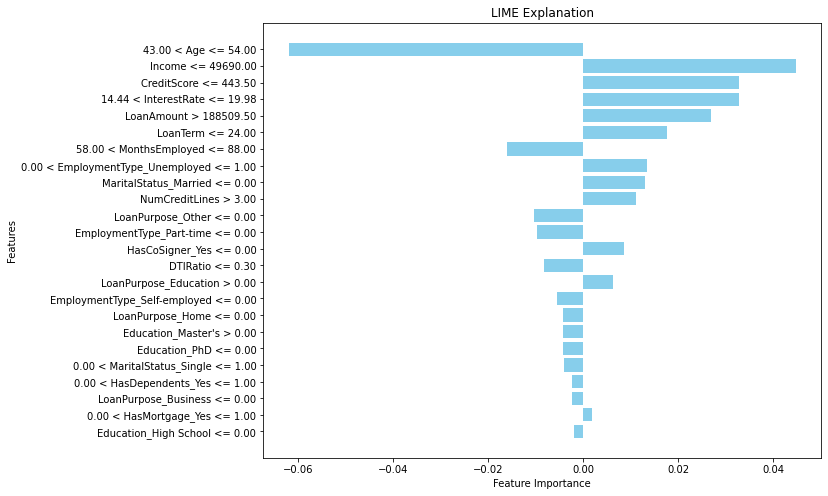

In [9]:
# Extract feature names and LIME explanation values
feature_names = explanation.as_list()
weights = [val[1] for val in feature_names]
features = [val[0] for val in feature_names]

# Plot LIME explanation
plt.figure(figsize=(10, 8))
plt.barh(features, weights, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('LIME Explanation')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


## Shap Explanations

In [12]:
# Create the explainer
explainer = shap.TreeExplainer(rf_model)

shap_values = explainer.shap_values(X_test)

In [13]:
shap_values = shap_values[:, :, 1]

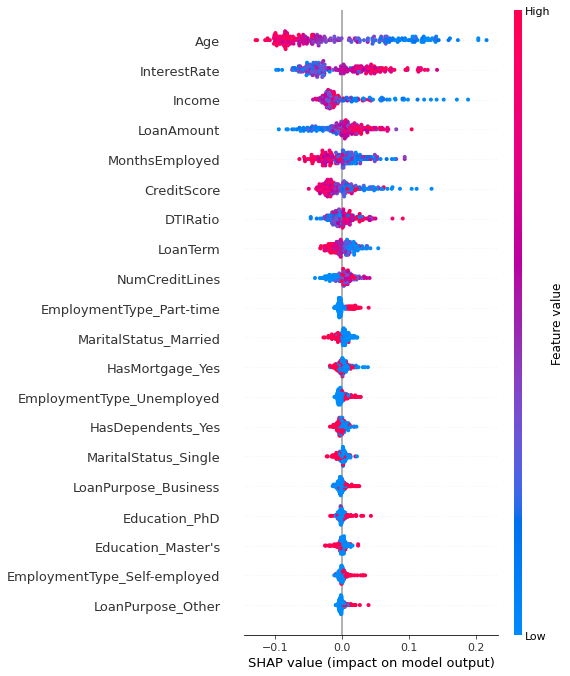

In [14]:
shap.summary_plot(shap_values, X_test)

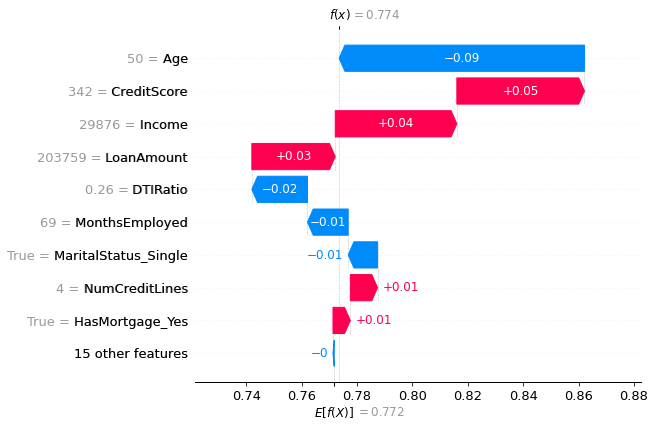

In [15]:
# Create an Explanation object using the SHAP values for the chosen instance
shap_explanation = shap.Explanation(values=shap_values[0], base_values=explainer.expected_value[0], data=X_test.iloc[0])

# Plot the waterfall plot for the chosen instance
shap.plots.waterfall(shap_explanation)

shap.plots.force(shap_explanation)



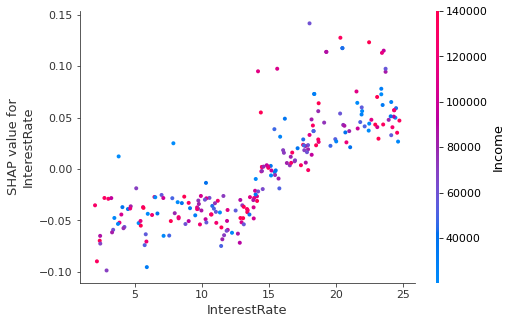

In [16]:
# Plot the dependence plot
shap.dependence_plot("InterestRate", shap_values, X_test, interaction_index='Income', show=False)

# Show the plot
plt.show()

In [17]:
# Create an Explanation object using the SHAP values for the chosen instance
shap_explanation = shap.Explanation(values=shap_values[:100], base_values=explainer.expected_value[0], data=X_test.iloc[:100])

# Plot the stacked force plot for the selected instances
shap.plots.force(shap_explanation, show=True)
